# Machine Learning Experiment - Exploratory Data Analysis
# Comprehensive performance comparison across multiple models and folds

## Setup and Imports

In [14]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from typing import List, Dict, Tuple
import re
import os

warnings.filterwarnings('ignore')

# Set style for professional, modern visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
sns.set_context("notebook", font_scale=1.2)

# Configure matplotlib for high-quality outputs
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# Show all rows
pd.set_option("display.max_rows", 1000)

# Show all columns
pd.set_option("display.max_columns", 27)

# Create output directory for images
output_dir = Path("results/images/baselines")
output_dir.mkdir(parents=True, exist_ok=True)

print("✅ Setup complete - Ready for analysis")

## Data Loading Functions

def load_fold_results(model_name: str, results_dir: str = "results") -> pd.DataFrame:
    """
    Load validation results for all folds of a specific model.
    
    Parameters:
    -----------
    model_name : str
        Name of the model (directory name in results/)
    results_dir : str
        Base directory containing results
        
    Returns:
    --------
    pd.DataFrame
        DataFrame containing all metrics for all folds and classes
    """
    val_path = Path(results_dir) / model_name / "val"
    
    if not val_path.exists():
        raise ValueError(f"Validation directory not found: {val_path}")
    
    # Find all result files
    result_files = sorted(val_path.glob("*_results.pt"))
    
    if not result_files:
        raise ValueError(f"No result files found in {val_path}")
    
    all_data = []
    
    for file_path in result_files:
        # Extract fold number from filename
        fold_match = re.search(r'fold(\d+)', file_path.name)
        if not fold_match:
            continue
            
        fold_num = int(fold_match.group(1))
        
        # Load PyTorch file
        result_data = torch.load(file_path, map_location='cpu')
        
        if result_data.get('status') != 'success':
            print(f"⚠️  Warning: Fold {fold_num} status is not 'success'")
            continue
        
        class_logs = result_data.get('class_logs', {})
        
        # Extract per-class metrics
        for key, value in class_logs.items():
            # Parse key: fold{X}/metric_classname or fold{X}/metric_mean
            parts = key.split('/')
            if len(parts) != 2:
                continue
                
            fold_part, metric_part = parts
            
            # Extract metric and class name
            metric_split = metric_part.split('_', 1)
            if len(metric_split) == 2:
                metric_name, class_name = metric_split
            else:
                continue
            
            all_data.append({
                'model': model_name,
                'fold': fold_num,
                'class': class_name,
                'metric': metric_name,
                'value': float(value)
            })
    
    if not all_data:
        raise ValueError(f"No data could be extracted from result files in {val_path}")
    
    df = pd.DataFrame(all_data)
    print(f"✅ Loaded {len(result_files)} folds for model '{model_name}'")
    print(f"   Total records: {len(df)} | Classes: {df['class'].nunique()} | Metrics: {df['metric'].nunique()}")
    
    return df


def load_multiple_models(model_names: List[str], results_dir: str = "results") -> pd.DataFrame:
    """
    Load validation results for multiple models and combine them.
    
    Parameters:
    -----------
    model_names : List[str]
        List of model names to load
    results_dir : str
        Base directory containing results
        
    Returns:
    --------
    pd.DataFrame
        Combined DataFrame with all models' metrics
    """
    all_dfs = []
    
    for model_name in model_names:
        try:
            df = load_fold_results(model_name, results_dir)
            all_dfs.append(df)
        except Exception as e:
            print(f"❌ Error loading model '{model_name}': {e}")
            continue
    
    if not all_dfs:
        raise ValueError("No models could be loaded successfully")
    
    combined_df = pd.concat(all_dfs, ignore_index=True)
    
    print(f"\n{'='*60}")
    print(f"📊 DATASET SUMMARY")
    print(f"{'='*60}")
    print(f"Models loaded: {len(all_dfs)}")
    print(f"Total records: {len(combined_df)}")
    print(f"Folds per model: {combined_df.groupby('model')['fold'].nunique().to_dict()}")
    print(f"{'='*60}\n")
    
    return combined_df


## Example Usage - Load Your Models

# Specify your model names (directory names in results/)
MODEL_NAMES = [
    "prova",
]

# Load data
# Uncomment and modify the following line with your actual model names:
df = load_multiple_models(MODEL_NAMES)

✅ Setup complete - Ready for analysis
✅ Loaded 4 folds for model 'prova'
   Total records: 96 | Classes: 4 | Metrics: 7

📊 DATASET SUMMARY
Models loaded: 1
Total records: 96
Folds per model: {'prova': 4}



In [15]:
df.head(100)

,model,fold,class,metric,value
0,prova,0,pothole,precision,0.526805
1,prova,0,pothole,recall,0.393557
2,prova,0,pothole,f1,0.450535
3,prova,0,pothole,ap50,0.418102
4,prova,0,pothole,ap,0.176671
5,prova,0,pothole,map,0.176671
6,prova,0,crack,precision,0.444100
7,prova,0,crack,recall,0.330320
8,prova,0,crack,f1,0.378852
9,prova,0,crack,ap50,0.347053


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   model   96 non-null     object 
 1   fold    96 non-null     int64  
 2   class   96 non-null     object 
 3   metric  96 non-null     object 
 4   value   96 non-null     float64
dtypes: float64(1), int64(1), object(3)
memory usage: 3.9+ KB


## Exploratory Data Analysis

### 1. Data Overview

In [3]:
print("="*80)
print("DATA STRUCTURE OVERVIEW")
print("="*80)
print(f"\nDataset Shape: {df.shape}")
print(f"\nColumn Types:\n{df.dtypes}")
print(f"\nFirst few rows:")
print(df.head(10))
print(f"\nBasic Statistics:")
print(df.describe())

DATA STRUCTURE OVERVIEW

Dataset Shape: (96, 5)

Column Types:
model      object
fold        int64
class      object
metric     object
value     float64
dtype: object

First few rows:
   model  fold    class     metric     value
0  prova     0  pothole  precision  0.526805
1  prova     0  pothole     recall  0.393557
2  prova     0  pothole         f1  0.450535
3  prova     0  pothole       ap50  0.418102
4  prova     0  pothole         ap  0.176671
5  prova     0  pothole        map  0.176671
6  prova     0    crack  precision  0.444100
7  prova     0    crack     recall  0.330320
8  prova     0    crack         f1  0.378852
9  prova     0    crack       ap50  0.347053

Basic Statistics:
            fold      value
count  96.000000  96.000000
mean    1.500000   0.423321
std     1.123903   0.188775
min     0.000000   0.129110
25%     0.750000   0.309209
50%     1.500000   0.426577
75%     2.250000   0.527828
max     3.000000   0.793952


### 2. Check for Missing Values

In [4]:
print("\n" + "="*80)
print("MISSING VALUES ANALYSIS")
print("="*80)
missing = df.isnull().sum()
print(f"\n{missing}")
print(f"\nTotal missing values: {missing.sum()}")


MISSING VALUES ANALYSIS

model     0
fold      0
class     0
metric    0
value     0
dtype: int64

Total missing values: 0


### 3. Unique Values per Column

In [5]:
print("\n" + "="*80)
print("UNIQUE VALUES ANALYSIS")
print("="*80)
for col in df.columns:
    unique_count = df[col].nunique()
    print(f"\n{col}: {unique_count} unique values")
    if unique_count < 20:
        print(f"  Values: {sorted(df[col].unique())}")


UNIQUE VALUES ANALYSIS

model: 1 unique values
  Values: ['prova']

fold: 4 unique values
  Values: [0, 1, 2, 3]

class: 4 unique values
  Values: ['crack', 'manhole', 'mean', 'pothole']

metric: 7 unique values
  Values: ['ap', 'ap50', 'ap75', 'f1', 'map', 'precision', 'recall']

value: 84 unique values


## Statistical Analysis

### 4. Overall Performance by Model

In [6]:
print("\n" + "="*80)
print("MODEL PERFORMANCE SUMMARY")
print("="*80)

# Calculate mean metrics across all folds and classes
model_summary = df.groupby(['model', 'metric'])['value'].agg(['mean', 'std', 'min', 'max']).reset_index()
model_summary = model_summary.round(4)

for model in df['model'].unique():
    print(f"\n{'─'*60}")
    print(f"Model: {model}")
    print(f"{'─'*60}")
    model_data = model_summary[model_summary['model'] == model]
    print(model_data.to_string(index=False))


MODEL PERFORMANCE SUMMARY

────────────────────────────────────────────────────────────
Model: prova
────────────────────────────────────────────────────────────
model    metric   mean    std    min    max
prova        ap 0.2267 0.1033 0.1291 0.3917
prova      ap50 0.5118 0.1481 0.3471 0.7710
prova      ap75 0.1541 0.0265 0.1318 0.1922
prova        f1 0.5281 0.1258 0.3789 0.7439
prova       map 0.2267 0.0887 0.1291 0.3917
prova precision 0.5611 0.1121 0.4441 0.7862
prova    recall 0.5036 0.1443 0.3303 0.7940


### 5. Performance by Class

In [7]:
print("\n" + "="*80)
print("PER-CLASS PERFORMANCE ANALYSIS")
print("="*80)

class_performance = df.groupby(['class', 'metric'])['value'].agg(['mean', 'std']).reset_index()
class_performance = class_performance.round(4)
print(class_performance)


PER-CLASS PERFORMANCE ANALYSIS
      class     metric    mean     std
0     crack         ap  0.1436  0.0161
1     crack       ap50  0.3745  0.0297
2     crack         f1  0.4080  0.0279
3     crack        map  0.1436  0.0161
4     crack  precision  0.4484  0.0066
5     crack     recall  0.3761  0.0468
6   manhole         ap  0.3640  0.0226
7   manhole       ap50  0.7425  0.0292
8   manhole         f1  0.7230  0.0195
9   manhole        map  0.3640  0.0226
10  manhole  precision  0.7285  0.0605
11  manhole     recall  0.7238  0.0557
12     mean       ap50  0.5118  0.0154
13     mean       ap75  0.1541  0.0265
14     mean         f1  0.5281  0.0147
15     mean        map  0.2267  0.0131
16     mean  precision  0.5611  0.0159
17     mean     recall  0.5036  0.0221
18  pothole         ap  0.1725  0.0122
19  pothole       ap50  0.4186  0.0067
20  pothole         f1  0.4534  0.0206
21  pothole        map  0.1725  0.0122
22  pothole  precision  0.5064  0.0243
23  pothole     recall  0.4109  

## Visualization Section
### 6. Overall Model Comparison - Mean Performance

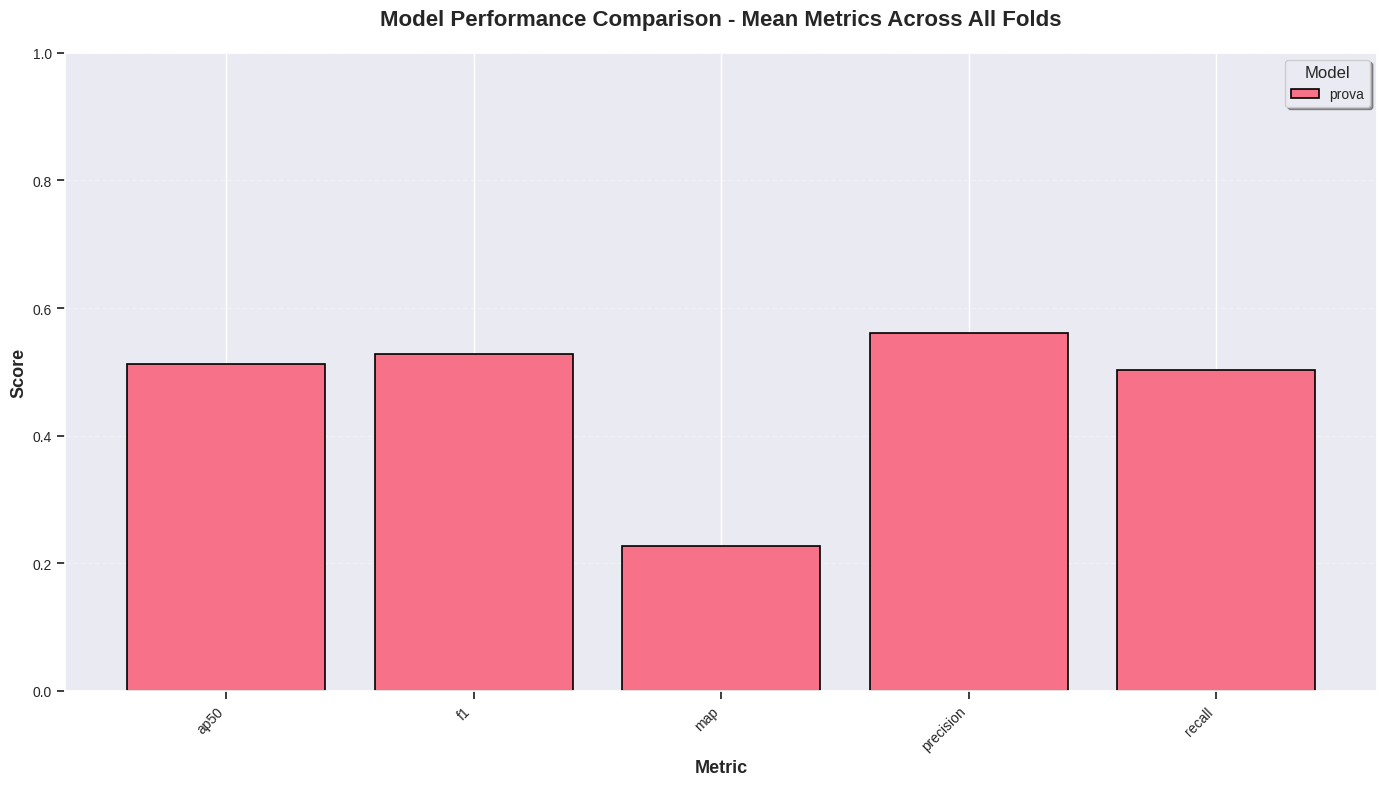

✅ Saved: 01_model_comparison_mean_metrics.png


In [8]:
### 6. Overall Model Comparison - Mean Performance

fig, ax = plt.subplots(figsize=(14, 8))

# Filter for mean metrics only
mean_metrics_df = df[df['class'] == 'mean'].copy()
metrics_to_plot = ['precision', 'recall', 'f1', 'ap50', 'ap', 'map']
mean_metrics_df = mean_metrics_df[mean_metrics_df['metric'].isin(metrics_to_plot)]

# Calculate mean across folds
plot_data = mean_metrics_df.groupby(['model', 'metric'])['value'].mean().reset_index()
plot_data_pivot = plot_data.pivot(index='metric', columns='model', values='value')

plot_data_pivot.plot(kind='bar', ax=ax, width=0.8, edgecolor='black', linewidth=1.2)

ax.set_title('Model Performance Comparison - Mean Metrics Across All Folds', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Metric', fontsize=13, fontweight='bold')
ax.set_ylabel('Score', fontsize=13, fontweight='bold')
ax.set_ylim([0, 1])
ax.legend(title='Model', title_fontsize=12, frameon=True, shadow=True)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig(output_dir / "01_model_comparison_mean_metrics.png", dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: 01_model_comparison_mean_metrics.png")

### 7. Heatmap - Model vs Metric Performance

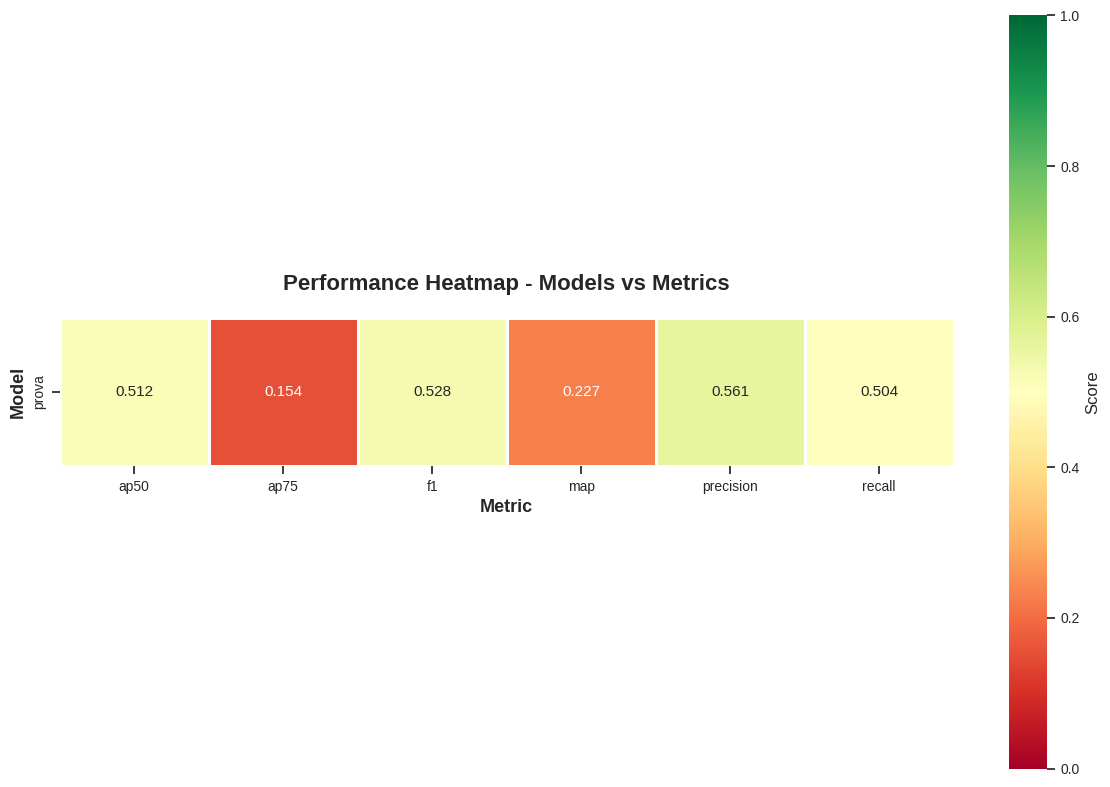

✅ Saved: 02_heatmap_model_metrics.png


In [9]:
fig, ax = plt.subplots(figsize=(12, 8))

heatmap_data = df[df['class'] == 'mean'].groupby(['model', 'metric'])['value'].mean().reset_index()
heatmap_pivot = heatmap_data.pivot(index='model', columns='metric', values='value')

sns.heatmap(heatmap_pivot, annot=True, fmt='.3f', cmap='RdYlGn', 
            cbar_kws={'label': 'Score'}, ax=ax, linewidths=2, 
            vmin=0, vmax=1, square=True)

ax.set_title('Performance Heatmap - Models vs Metrics', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Metric', fontsize=13, fontweight='bold')
ax.set_ylabel('Model', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig(output_dir / "02_heatmap_model_metrics.png", dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: 02_heatmap_model_metrics.png")

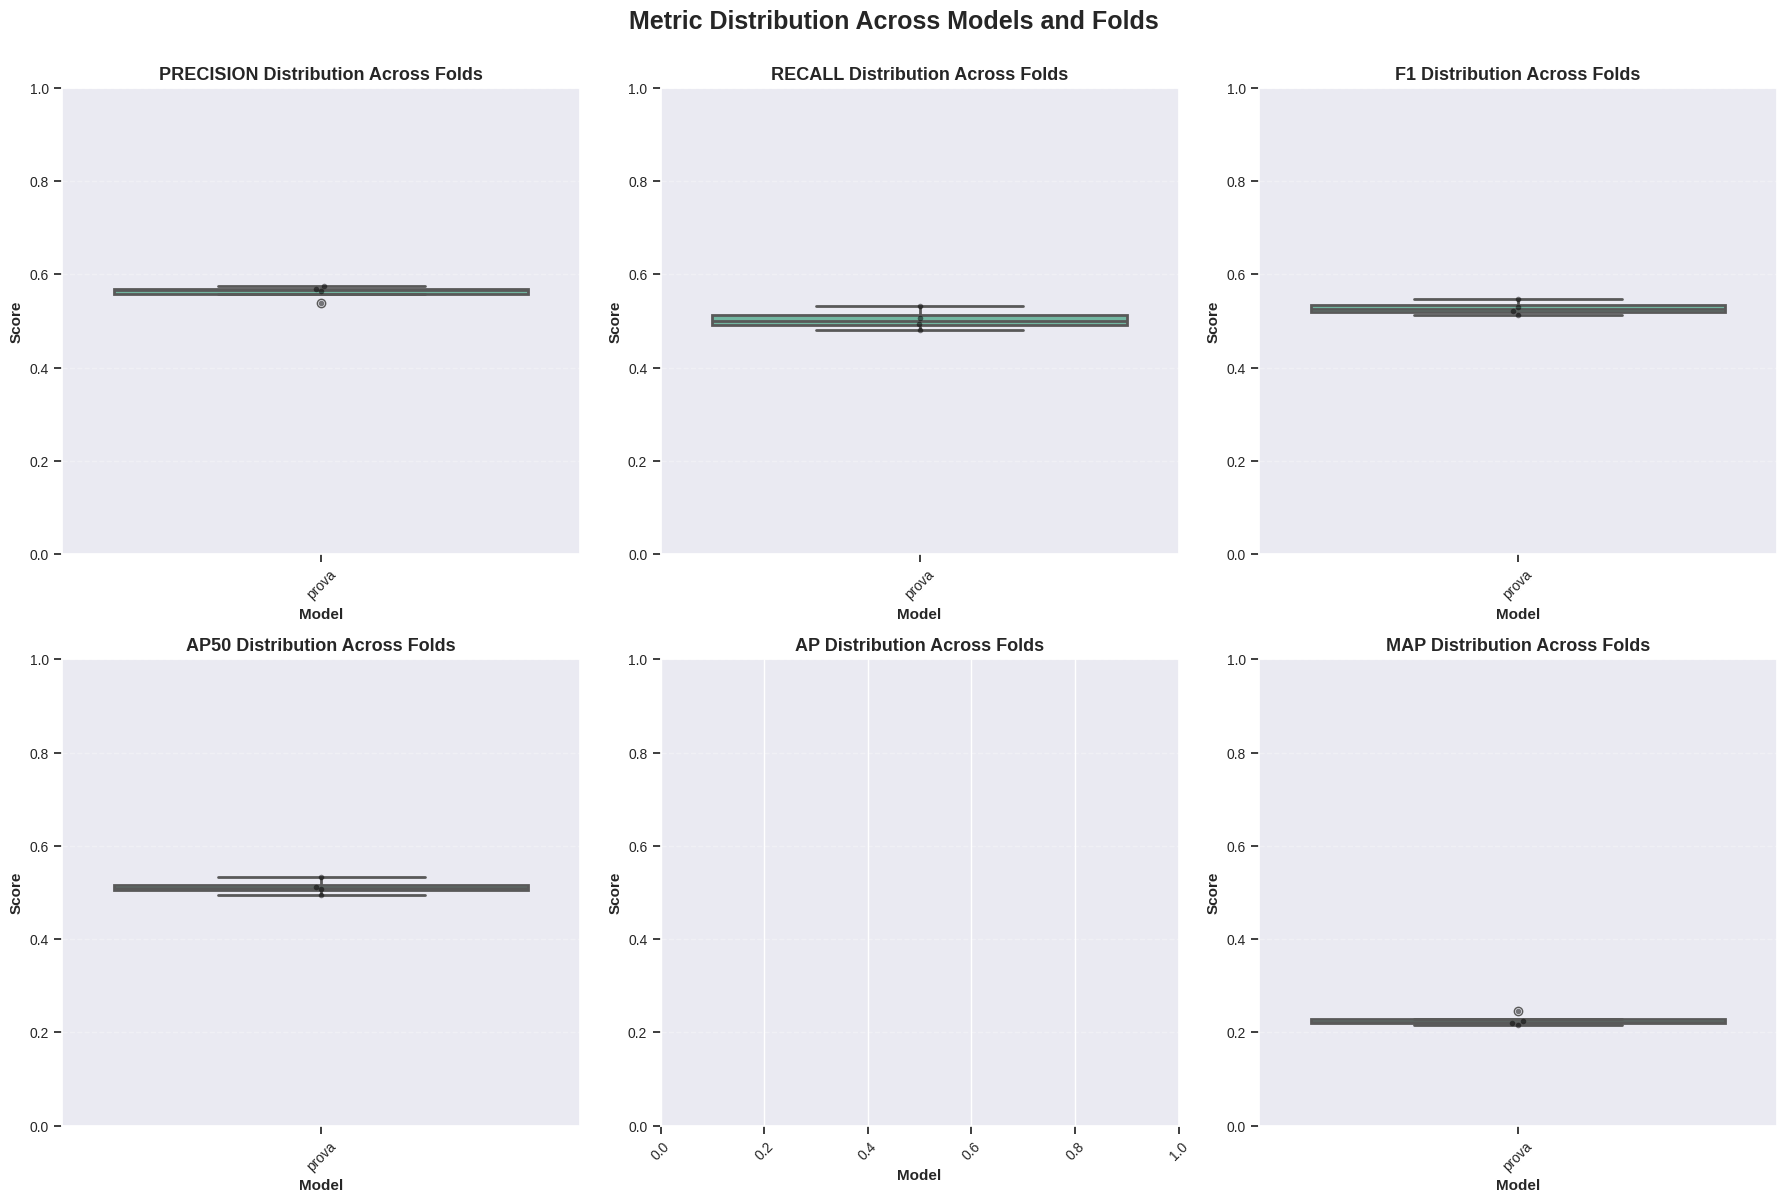

✅ Saved: 03_boxplot_fold_distribution.png


In [10]:
### 8. Box Plot - Distribution Across Folds

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

metrics_to_plot = ['precision', 'recall', 'f1', 'ap50', 'ap', 'map']
mean_data = df[df['class'] == 'mean'].copy()

for idx, metric in enumerate(metrics_to_plot):
    metric_data = mean_data[mean_data['metric'] == metric]
    
    sns.boxplot(data=metric_data, x='model', y='value', ax=axes[idx], 
                palette='Set2', linewidth=2)
    sns.swarmplot(data=metric_data, x='model', y='value', ax=axes[idx], 
                  color='black', alpha=0.5, size=4)
    
    axes[idx].set_title(f'{metric.upper()} Distribution Across Folds', 
                        fontsize=13, fontweight='bold')
    axes[idx].set_xlabel('Model', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Score', fontsize=11, fontweight='bold')
    axes[idx].set_ylim([0, 1])
    axes[idx].grid(axis='y', alpha=0.3, linestyle='--')
    axes[idx].tick_params(axis='x', rotation=45)

plt.suptitle('Metric Distribution Across Models and Folds', 
             fontsize=18, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(output_dir / "03_boxplot_fold_distribution.png", dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: 03_boxplot_fold_distribution.png")